In [1]:
import pandas as pd
import numpy as np
import nltk
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [2]:
data = pd.read_table("yelp_labelled.txt", names=["Review", "Sentiment"], header=None)

In [3]:
data.head()

,Review,Sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [4]:
data.keys()

Index(['Review', 'Sentiment'], dtype='object')

In [5]:
data["Sentiment"].value_counts()

Sentiment
1    500
0    500
Name: count, dtype: int64

In [6]:
data = data.astype({"Review":"string"})

In [7]:
text = data["Review"]
text[:5]

0                             Wow... Loved this place.
1                                   Crust is not good.
2            Not tasty and the texture was just nasty.
3    Stopped by during the late May bank holiday of...
4    The selection on the menu was great and so wer...
Name: Review, dtype: string

In [8]:
# Get rid of useless characters
transformed_text = []

for review in text:

    review = review.translate(str.maketrans('','',string.punctuation))
    review = review.translate(str.maketrans('','',string.digits))
    review = review.lower()
    transformed_text.append(review)

transformed_text[:5]

['wow loved this place',
 'crust is not good',
 'not tasty and the texture was just nasty',
 'stopped by during the late may bank holiday off rick steve recommendation and loved it',
 'the selection on the menu was great and so were the prices']

In [9]:
# Numbered data
transformed_text = pd.Series(transformed_text)
transformed_text[:5]

0                                 wow loved this place
1                                    crust is not good
2             not tasty and the texture was just nasty
3    stopped by during the late may bank holiday of...
4    the selection on the menu was great and so wer...
dtype: object

In [14]:
import spacy
nlp = spacy.load("en_core_web_sm")

# Define custom stop words list with exceptions for negations
custom_stop_words = set(word for word in nlp.Defaults.stop_words if word.lower() not in ['not', 'no', 'never'])

def remove_stop_words(text):
    doc = nlp(text)
    return ' '.join(token.text for token in doc if token.text.lower() not in custom_stop_words)

transformed_text = transformed_text.apply(remove_stop_words)

print(transformed_text[:5])

0                                      wow loved place
1                                       crust not good
2                              not tasty texture nasty
3    stopped late bank holiday rick steve recommend...
4                          selection menu great prices
dtype: object


In [15]:
# lemmatising, bring words to root word
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J":wordnet.ADJ,
                "N":wordnet.NOUN,
                "V":wordnet.VERB,
                "R":wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Lemmatize with POS tags
lemmatizer = WordNetLemmatizer()
lemmatized_text = transformed_text.apply(lambda x: ' '.join(lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in x.split()))
lemmatized_text[:5]

0                                       wow love place
1                                       crust not good
2                              not tasty texture nasty
3    stop late bank holiday rick steve recommendati...
4                           selection menu great price
dtype: object

In [ ]:
ps = nltk.PorterStemmer()

stemmed_text = transformed_text.apply(lambda text: ' '.join(ps.stem(term) for term in text.split()))
stemmed_text[:5]

0                                      wow love place
1                                      crust not good
2                              not tasti textur nasti
3    stop late bank holiday rick steve recommend love
4                             select menu great price
dtype: object

In [16]:
reviews = list(zip(lemmatized_text, data["Sentiment"]))

prepared_data = pd.DataFrame(reviews, columns=["Review", "Sentiment"])
prepared_data

,Review,Sentiment
0,wow love place,1
1,crust not good,0
2,not tasty texture nasty,0
3,stop late bank holiday rick steve recommendati...,1
4,selection menu great price,1
...,...,...
995,think food flavor texture lack,0
996,appetite instantly go,0
997,overall not impressed not,0
998,experience underwhelming think ninja sushi time,0


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Bag of Words Representation
tv=TfidfVectorizer()

tv_data = tv.fit_transform(prepared_data["Review"])
print(tv_data.shape)
print(tv.get_feature_names_out())


(1000, 1569)
['absolute' 'absolutely' 'absolutley' ... 'yum' 'yummy' 'zero']


In [18]:
x_train = tv_data[:850]
x_test = tv_data[850:]
y_train = prepared_data["Sentiment"][:850]
y_test = prepared_data["Sentiment"][850:]

In [19]:
# Classification
# NN
# Bagging
# SVM
# Gradient Boosting Tree
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

In [26]:
# Neural Net
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=1, hidden_layer_sizes=10, learning_rate_init=0.01, activation="tanh")

mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)

cv_scores = cross_val_score(mlp, x_train, y_train, cv=5)  # 5-fold cross-validation

# Print cross-validated accuracy scores
print("Cross-Validated Accuracy Scores:", cv_scores)
print("Mean Accuracy: ", np.mean(cv_scores))

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

conf_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred), "\n")
print("Mean Absolute Error: ", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)), "\n")

print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Cross-Validated Accuracy Scores: [0.78235294 0.77058824 0.74705882 0.79411765 0.77058824]
Mean Accuracy:  0.7729411764705881
[[88 32]
 [ 7 23]] 

Mean Absolute Error:  0.26
Mean Squared Error:  0.26
Root Mean Squared Error:  0.5099019513592785 

              precision    recall  f1-score   support

           0       0.93      0.73      0.82       120
           1       0.42      0.77      0.54        30

    accuracy                           0.74       150
   macro avg       0.67      0.75      0.68       150
weighted avg       0.82      0.74      0.76       150

Accuracy:  0.74


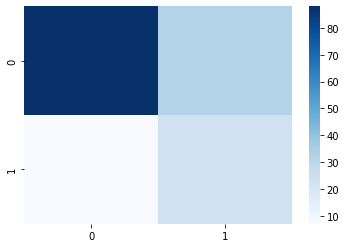

In [18]:
sb.heatmap(conf_matrix, cmap="Blues")
plt.show()

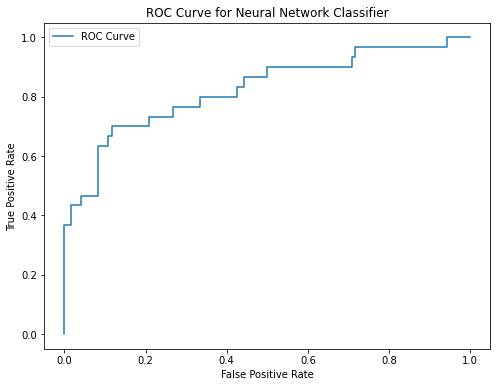

AUC-ROC Score:  0.8247222222222221


In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = mlp.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Neural Network Classifier')
plt.legend()
plt.show()

auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score: ", auc_score)


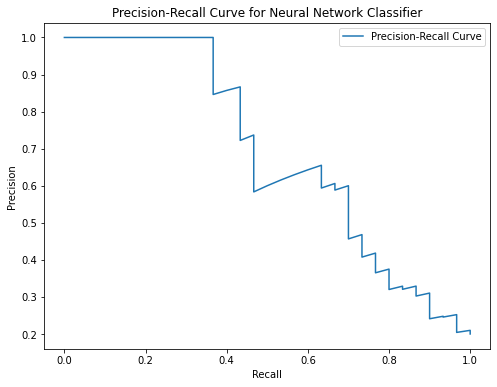

In [27]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Neural Network Classifier')
plt.legend()
plt.show()


In [35]:
# Bagging
from sklearn.ensemble import BaggingClassifier

bc = BaggingClassifier(random_state=1, n_estimators=5)

bc.fit(x_train, y_train)
y_pred = bc.predict(x_test)

cv_scores = cross_val_score(bc, x_train, y_train, cv=5)  # 5-fold cross-validation

# Print cross-validated accuracy scores
print("Cross-Validated Accuracy Scores:", cv_scores)
print("Mean Accuracy: ", np.mean(cv_scores))

conf_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred), "\n")
print("Mean Absolute Error: ", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)), "\n")

print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Cross-Validated Accuracy Scores: [0.72352941 0.75882353 0.70588235 0.76470588 0.74705882]
Mean Accuracy:  0.74
[[79 41]
 [ 3 27]] 

Mean Absolute Error:  0.29333333333333333
Mean Squared Error:  0.29333333333333333
Root Mean Squared Error:  0.5416025603090641 

              precision    recall  f1-score   support

           0       0.96      0.66      0.78       120
           1       0.40      0.90      0.55        30

    accuracy                           0.71       150
   macro avg       0.68      0.78      0.67       150
weighted avg       0.85      0.71      0.74       150

Accuracy:  0.7066666666666667


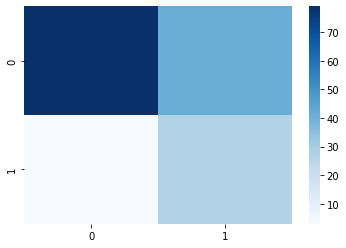

In [39]:
sb.heatmap(conf_matrix, cmap="Blues")
plt.show()

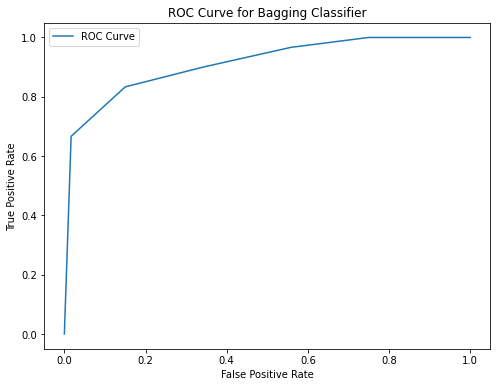

AUC-ROC Score:  0.9123611111111112


In [37]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = bc.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Bagging Classifier')
plt.legend()
plt.show()

auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score: ", auc_score)

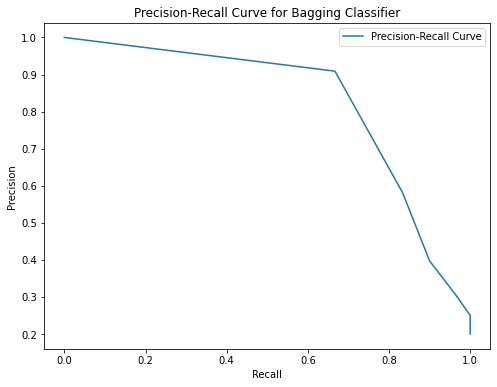

In [38]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Bagging Classifier')
plt.legend()
plt.show()

In [45]:
# SVM
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear', probability=True)

svm_classifier.fit(x_train, y_train)
y_pred = svm_classifier.predict(x_test)

cv_scores = cross_val_score(svm_classifier, x_train, y_train, cv=5)  # 5-fold cross-validation

# Print cross-validated accuracy scores
print("Cross-Validated Accuracy Scores:", cv_scores)
print("Mean Accuracy: ", np.mean(cv_scores))

conf_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred), "\n")
print("Mean Absolute Error: ", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)), "\n")

print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))


Cross-Validated Accuracy Scores: [0.81176471 0.81764706 0.78235294 0.85882353 0.77647059]
Mean Accuracy:  0.8094117647058823
[[97 23]
 [ 5 25]] 

Mean Absolute Error:  0.18666666666666668
Mean Squared Error:  0.18666666666666668
Root Mean Squared Error:  0.43204937989385733 

              precision    recall  f1-score   support

           0       0.95      0.81      0.87       120
           1       0.52      0.83      0.64        30

    accuracy                           0.81       150
   macro avg       0.74      0.82      0.76       150
weighted avg       0.86      0.81      0.83       150

Accuracy:  0.8133333333333334


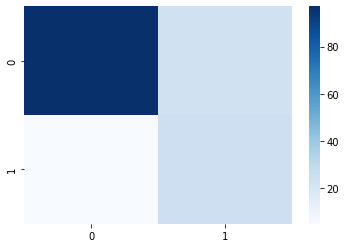

In [46]:
sb.heatmap(conf_matrix, cmap="Blues")
plt.show()

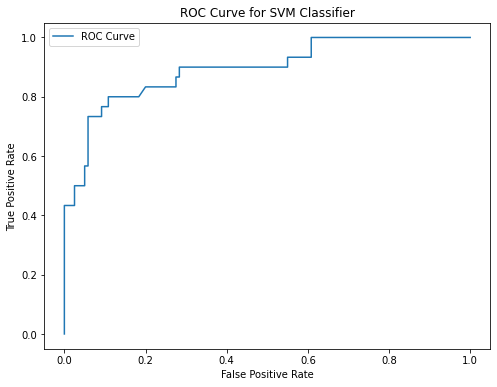

AUC-ROC Score:  0.8947222222222223


In [47]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = svm_classifier.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Classifier')
plt.legend()
plt.show()

auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score: ", auc_score)

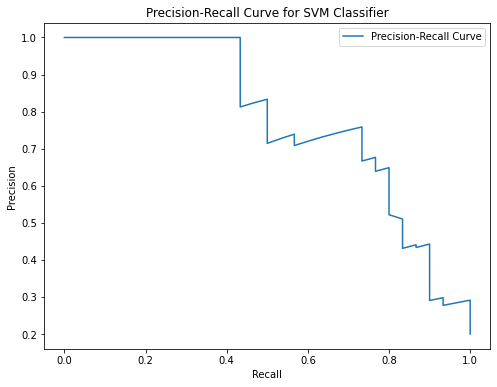

In [48]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for SVM Classifier')
plt.legend()
plt.show()

In [70]:
# Gradient Boosting Tree
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(random_state=12, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.8)

gbm.fit(x_train, y_train)
y_pred = gbm.predict(x_test)

cv_scores = cross_val_score(gbm, x_train, y_train, cv=5)  # 5-fold cross-validation

# Print cross-validated accuracy scores
print("Cross-Validated Accuracy Scores:", cv_scores)
print("Mean Accuracy: ", np.mean(cv_scores))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred), "\n")
print("Mean Absolute Error: ", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)), "\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Cross-Validated Accuracy Scores: [0.74705882 0.78235294 0.77058824 0.76470588 0.78823529]
Mean Accuracy:  0.7705882352941176
Confusion Matrix:
[[84 36]
 [ 3 27]] 

Mean Absolute Error:  0.26
Mean Squared Error:  0.26
Root Mean Squared Error:  0.5099019513592785 

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.70      0.81       120
           1       0.43      0.90      0.58        30

    accuracy                           0.74       150
   macro avg       0.70      0.80      0.70       150
weighted avg       0.86      0.74      0.77       150

Accuracy:  0.74


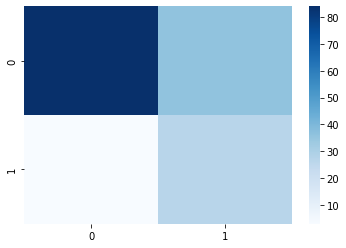

In [71]:
sb.heatmap(conf_matrix, cmap="Blues")
plt.show()

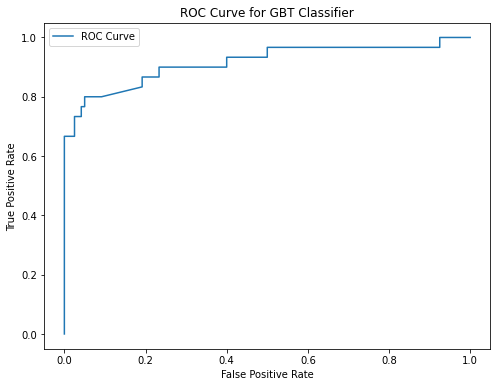

AUC-ROC Score:  0.9155555555555556


In [72]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = gbm.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GBT Classifier')
plt.legend()
plt.show()

auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score: ", auc_score)

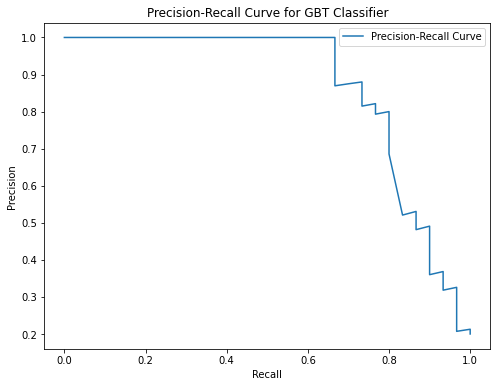

In [73]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for GBT Classifier')
plt.legend()
plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mwver\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        96
           1       0.93      0.77      0.84       104

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200

Confusion Matrix:
[[90  6]
 [24 80]]


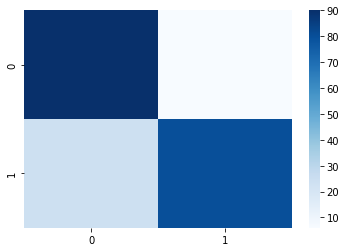

Epoch 2/3, Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.76      0.82        96
           1       0.81      0.92      0.86       104

    accuracy                           0.84       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.85      0.84      0.84       200

Confusion Matrix:
[[73 23]
 [ 8 96]]


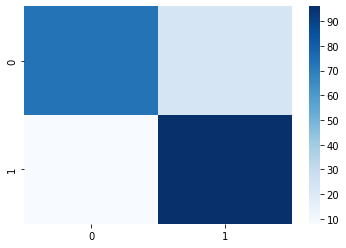

Epoch 3/3, Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        96
           1       0.92      0.84      0.87       104

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.87       200
weighted avg       0.88      0.88      0.87       200

Confusion Matrix:
[[88  8]
 [17 87]]


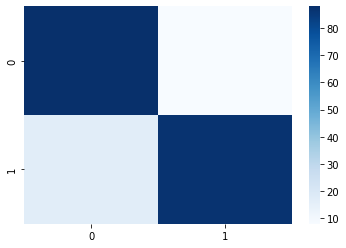

('fine_tuned_bert_model\\tokenizer_config.json',
 'fine_tuned_bert_model\\special_tokens_map.json',
 'fine_tuned_bert_model\\vocab.txt',
 'fine_tuned_bert_model\\added_tokens.json')

In [79]:
# Bert Uncased
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

x_train, x_test, y_train, y_test = train_test_split(
    prepared_data['Review'],
    prepared_data['Sentiment'],
    test_size=0.2,
    random_state=42
)

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, text, labels, tokenizer, max_len):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = str(self.text.iloc[idx])
        label = int(self.labels.iloc[idx])
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Tokenize the data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128

train_dataset = CustomDataset(x_train, y_train, tokenizer, max_len)
test_dataset = CustomDataset(x_test, y_test, tokenizer, max_len)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(prepared_data['Sentiment'].unique()))

# Define optimizer and learning rate
optimizer = AdamW(model.parameters(), lr=2e-5)

# Fine-tune the BERT model
num_epochs = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluate on the test set
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert predictions and labels to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Print classification report
    report = classification_report(all_labels, all_predictions)
    print(f'Epoch {epoch + 1}/{num_epochs}, Classification Report:\n{report}')

    # Print confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_predictions)
    print(f'Confusion Matrix:\n{confusion_mat}')
    sb.heatmap(confusion_mat, cmap="Blues")
    plt.show()


# Save the fine-tuned model so I dont have to go through this pain again......
model.save_pretrained('fine_tuned_bert_model')
tokenizer.save_pretrained('fine_tuned_bert_model')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mwver\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        96
           1       0.88      0.84      0.86       104

    accuracy                           0.85       200
   macro avg       0.86      0.86      0.85       200
weighted avg       0.86      0.85      0.86       200

Confusion Matrix:
[[84 12]
 [17 87]]


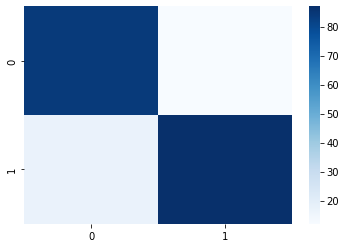

Epoch 2/3, Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.70      0.79        96
           1       0.77      0.94      0.85       104

    accuracy                           0.82       200
   macro avg       0.84      0.82      0.82       200
weighted avg       0.84      0.82      0.82       200

Confusion Matrix:
[[67 29]
 [ 6 98]]


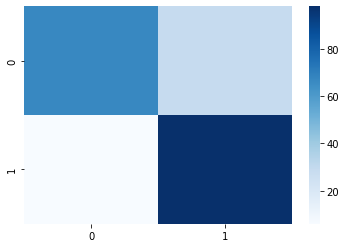

Epoch 3/3, Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86        96
           1       0.94      0.77      0.85       104

    accuracy                           0.85       200
   macro avg       0.87      0.86      0.85       200
weighted avg       0.87      0.85      0.85       200

Confusion Matrix:
[[91  5]
 [24 80]]


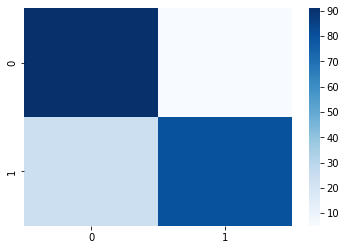

('fine_tuned_bert_model_large\\tokenizer_config.json',
 'fine_tuned_bert_model_large\\special_tokens_map.json',
 'fine_tuned_bert_model_large\\vocab.txt',
 'fine_tuned_bert_model_large\\added_tokens.json')

In [80]:
# Big boy bert
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

x_train, x_test, y_train, y_test = train_test_split(
    prepared_data['Review'],
    prepared_data['Sentiment'],
    test_size=0.2,
    random_state=42
)

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, text, labels, tokenizer, max_len):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = str(self.text.iloc[idx])
        label = int(self.labels.iloc[idx])
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Tokenize the data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
max_len = 128

train_dataset = CustomDataset(x_train, y_train, tokenizer, max_len)
test_dataset = CustomDataset(x_test, y_test, tokenizer, max_len)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=len(prepared_data['Sentiment'].unique()))  # Corrected model name

# Define optimizer and learning rate
optimizer = AdamW(model.parameters(), lr=2e-5)

# Fine-tune the BERT model
num_epochs = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluate on the test set
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert predictions and labels to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Print classification report
    report = classification_report(all_labels, all_predictions)
    print(f'Epoch {epoch + 1}/{num_epochs}, Classification Report:\n{report}')

    # Print confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_predictions)
    print(f'Confusion Matrix:\n{confusion_mat}')
    sb.heatmap(confusion_mat, cmap="Blues")
    plt.show()

# Save the fine-tuned model
model.save_pretrained('fine_tuned_bert_model_large')
tokenizer.save_pretrained('fine_tuned_bert_model_large')


In [31]:
# Topic Detection
import gensim
from gensim.utils import simple_preprocess

prepared_data

,Review,Sentiment
0,wow love place,1
1,crust not good,0
2,not tasty texture nasty,0
3,stop late bank holiday rick steve recommendati...,1
4,selection menu great price,1
...,...,...
995,think food flavor texture lack,0
996,appetite instantly go,0
997,overall not impressed not,0
998,experience underwhelming think ninja sushi time,0


In [33]:
data = prepared_data.values.tolist()
data

[['wow love place', 1],
 ['crust not good', 0],
 ['not tasty texture nasty', 0],
 ['stop late bank holiday rick steve recommendation love', 1],
 ['selection menu great price', 1],
 ['get angry want damn pho', 0],
 ['honeslty nt taste fresh', 0],
 ['potato like rubber tell ahead time kept warmer', 0],
 ['fry great', 1],
 ['great touch', 1],
 ['service prompt', 1],
 ['not', 0],
 ['cashier no care end wayyy overprice', 0],
 ['try cape cod ravoli chickenwith cranberrymmmm', 1],
 ['disgust pretty sure human hair', 0],
 ['shock no sign indicate cash', 0],
 ['highly recommend', 1],
 ['waitress little slow service', 0],
 ['place not worth time let vega', 0],
 ['not like', 0],
 ['burrittos blah', 0],
 ['food amaze', 1],
 ['service cute', 1],
 ['care interior beautiful', 1],
 ['perform', 1],
 ['s rightthe red velvet cakeohhh stuff good', 1],
 ['never brought salad ask', 0],
 ['hole wall great mexican street taco friendly staff', 1],
 ['take hour food table restaurant food luke warm sever run lik

In [34]:
# Tokenisation

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

words = list(sent_to_words(data))
print(words[:1])

[['wow', 'love', 'place']]


In [35]:
# Prepare for LDA
import gensim.corpora as corpora

id2word = corpora.Dictionary(words)

texts = words

corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [37]:
from pprint import pprint

num_topics = 8

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.027*"place" + 0.022*"like" + 0.022*"food" + 0.018*"service" + 0.016*"bad" '
  '+ 0.013*"good" + 0.013*"experience" + 0.011*"wait" + 0.010*"not" + '
  '0.010*"nt"'),
 (1,
  '0.030*"nt" + 0.023*"not" + 0.018*"good" + 0.017*"time" + 0.016*"place" + '
  '0.013*"wo" + 0.012*"restaurant" + 0.009*"go" + 0.009*"food" + 0.007*"get"'),
 (2,
  '0.034*"not" + 0.023*"place" + 0.018*"good" + 0.017*"food" + 0.012*"come" + '
  '0.010*"like" + 0.010*"service" + 0.009*"love" + 0.009*"minute" + '
  '0.007*"bad"'),
 (3,
  '0.060*"food" + 0.027*"good" + 0.018*"service" + 0.016*"place" + 0.014*"eat" '
  '+ 0.013*"great" + 0.013*"not" + 0.011*"come" + 0.009*"nt" + '
  '0.009*"chicken"'),
 (4,
  '0.034*"great" + 0.022*"place" + 0.017*"nt" + 0.011*"service" + 0.011*"time" '
  '+ 0.010*"fresh" + 0.009*"taste" + 0.008*"vega" + 0.008*"sushi" + '
  '0.008*"overprice"'),
 (5,
  '0.031*"nt" + 0.025*"not" + 0.015*"good" + 0.015*"food" + 0.014*"service" + '
  '0.013*"great" + 0.011*"place" + 0.009*"come" + 0

In [39]:
import pyLDAvis.gensim_models
import pyLDAvis

pyLDAvis.enable_notebook()

LDavis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDavis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.048458 -0.025541       1        1  17.401197
0      0.020665 -0.018673       2        1  14.256495
1      0.067924  0.032584       3        1  14.165552
5      0.028190  0.008686       4        1  13.362450
4     -0.041947 -0.140132       5        1  12.452043
2     -0.018236  0.048675       6        1  10.314593
6      0.034357  0.042213       7        1  10.267361
7     -0.139410  0.052187       8        1   7.780309, topic_info=           Term       Freq      Total Category  logprob  loglift
73         food  99.000000  99.000000  Default  30.0000  30.0000
5           not  90.000000  90.000000  Default  29.0000  29.0000
16        great  54.000000  54.000000  Default  28.0000  28.0000
27           nt  77.000000  77.000000  Default  27.0000  27.0000
31         like  40.000000  40.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
87     friendly   1.525915  20.669823   Topic8  -5.5436  -0.0525
100       table   1.525452  11.164694   Topic8  -5.5439   0.5631
465        seat   1.525391   7.471066   Topic8  -5.5440   0.9648
7         tasty   1.525350   8.983156   Topic8  -5.5440   0.7804
370  atmosphere   1.525323   9.353854   Topic8  -5.5440   0.7400

[605 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
478       3  0.646410         ago
478       5  0.323205         ago
1432      2  0.645475  albondigas
72        1  0.166412       amaze
72        2  0.055471       amaze
...     ...       ...         ...
654       8  0.912083         yum
505       2  0.224515        zero
505       4  0.224515        zero
505       6  0.449031        zero
505       7  0.224515        zero

[1083 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 6, 5, 3, 7, 8])

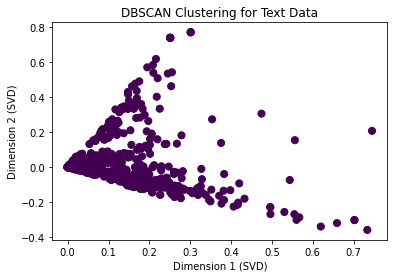

In [44]:
# DBSCAN Clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

text_data = prepared_data['Review']

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(text_data)

# Apply dimensionality reduction using Truncated SVD (for visualisation purposes)
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X_svd)

# Visualize the clusters
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=labels, cmap='viridis', s=50)
plt.title('DBSCAN Clustering for Text Data')
plt.xlabel('Dimension 1 (SVD)')
plt.ylabel('Dimension 2 (SVD)')
plt.show()

